# ML4NLP1 - Tutorial 03: `skorch`

[`skorch`](https://skorch.readthedocs.io/en/stable/index.html) is a library that wraps pytorch in a convenient `sk-learn`-style syntax.

This gives us access to define customised neural networks and train, develop, and evaluate them using a familiar and simple syntax (e.g. `fit()` and `predict()`, as well as all the convenence tools like `make_pipe()`, `cross_validation` and `GridSearchCV`,



## Installing skorch and loading libraries

In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch'])
except ImportError:
    pass

In [2]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

In [3]:
# set seed for reproducibility
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Data Loading and Preparation

In [4]:
import os
import pandas as pd

from sklearn.datasets import fetch_20newsgroups


# For demonstration, we're going to take just a subset of the 20 available categories...
categories = [
    'alt.atheism',
    'soc.religion.christian',
    'comp.graphics',
    'sci.med'
    ]

twenty_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=SEED
)

twenty_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=SEED
)

print(dir(twenty_train))
print(twenty_train.filenames)
print(twenty_train.target_names)

['DESCR', 'data', 'filenames', 'target', 'target_names']
['/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38440'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38479'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/soc.religion.christian/20737'
 ...
 '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.med/58112'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.med/58578'
 '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.med/58895']
['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


In [5]:
# For simplicity, we'll convert the sklearn dataset into a Panda's dataframe
train_df = pd.DataFrame({'text': twenty_train.data, 'label': twenty_train.target})
test_df = pd.DataFrame({'text': twenty_test.data, 'label': twenty_test.target})

# Note, this step converts the numerical target labels to their corresponding strings (only for didactic purposes!)
train_df['label'] = train_df['label'].apply(lambda x: twenty_train.target_names[x])
test_df['label'] = test_df['label'].apply(lambda x: twenty_train.target_names[x])

In [6]:
# Set variable names for inputs and outputs to make things a bit easier.
X_train = train_df.text.to_numpy()
y_train = train_df.label.to_numpy()
X_test = test_df.text.to_numpy()
y_test = test_df.label.to_numpy()

# Check what we got
print(f'Train X is a {type(X_train)} with shape: {X_train.shape}')
print(f'Train Y is a {type(y_train)} with shape: {y_train.shape}')
print(f'Test X is a {type(X_test)} with shape: {X_test.shape}')
print(f'Test Y is a {type(y_test)} with shape: {y_test.shape}')


Train X is a <class 'numpy.ndarray'> with shape: (2257,)
Train Y is a <class 'numpy.ndarray'> with shape: (2257,)
Test X is a <class 'numpy.ndarray'> with shape: (1502,)
Test Y is a <class 'numpy.ndarray'> with shape: (1502,)


In [7]:
from sklearn.preprocessing import LabelEncoder


# Initialise the LabelEncoder
label_encoder = LabelEncoder()

print(type(y_train))
print(y_train[:4])

# Fit and apply the LabelEncoder
y_train = label_encoder.fit(y_train).transform(y_train) # equivalent to `.fit_transform(y_train)`

print(type(y_train))
print(y_train[:4])

# Don't forget the test labels!
y_test = label_encoder.transform(y_test)


<class 'numpy.ndarray'>
['comp.graphics' 'comp.graphics' 'soc.religion.christian'
 'soc.religion.christian']
<class 'numpy.ndarray'>
[1 1 3 3]


In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Fit and apply count vectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)  # num_docs x num_words
X_test_counts = count_vect.transform(X_test)

# Fit and apply tfidf vectorizer
tfidf_tranformer = TfidfTransformer(smooth_idf=True).fit(X_train_counts)
X_train_tfidf = tfidf_tranformer.transform(X_train_counts)
X_test_tfidf = tfidf_tranformer.transform(X_test_counts)


In [9]:
print(f'Train X is a {type(X_train_tfidf)} with shape: {X_train_tfidf.shape}, and dtype: {X_train_tfidf.dtype}')
print(f'Train Y is a {type(y_train)} with shape: {y_train.shape}, and dtype: {y_train.dtype}')

Train X is a <class 'scipy.sparse._csr.csr_matrix'> with shape: (2257, 35788), and dtype: float64
Train Y is a <class 'numpy.ndarray'> with shape: (2257,), and dtype: int64


In [10]:
X_train_tfidf = X_train_tfidf.astype(np.float32)
y_train = y_train.astype(np.int64)

print(f'Train X is a {type(X_train_tfidf)} with shape: {X_train_tfidf.shape}, and dtype: {X_train_tfidf.dtype}')
print(f'Train Y is a {type(y_train)} with shape: {y_train.shape}, and dtype: {y_train.dtype}')

Train X is a <class 'scipy.sparse._csr.csr_matrix'> with shape: (2257, 35788), and dtype: float32
Train Y is a <class 'numpy.ndarray'> with shape: (2257,), and dtype: int64


## Neural Network Architecture

Decisions on
1. Input Dimension
2. Number of Hidden Layers
3. Dimension of Hidden Layers
4. Non-linearity function
5. Dimension of Output Layer
6. Regularization (Dropouts, Different Loss)

In the following, we define a vanilla neural network with two hidden layers.

The output layer should have as many outputs as there are classes.

In addition, it should have a nonlinearity function.

#### 🗒❓ What should be the Input Dimension for our dataset?
#### 🗒❓ What is +1 in the NN image below?


<div align="center">
  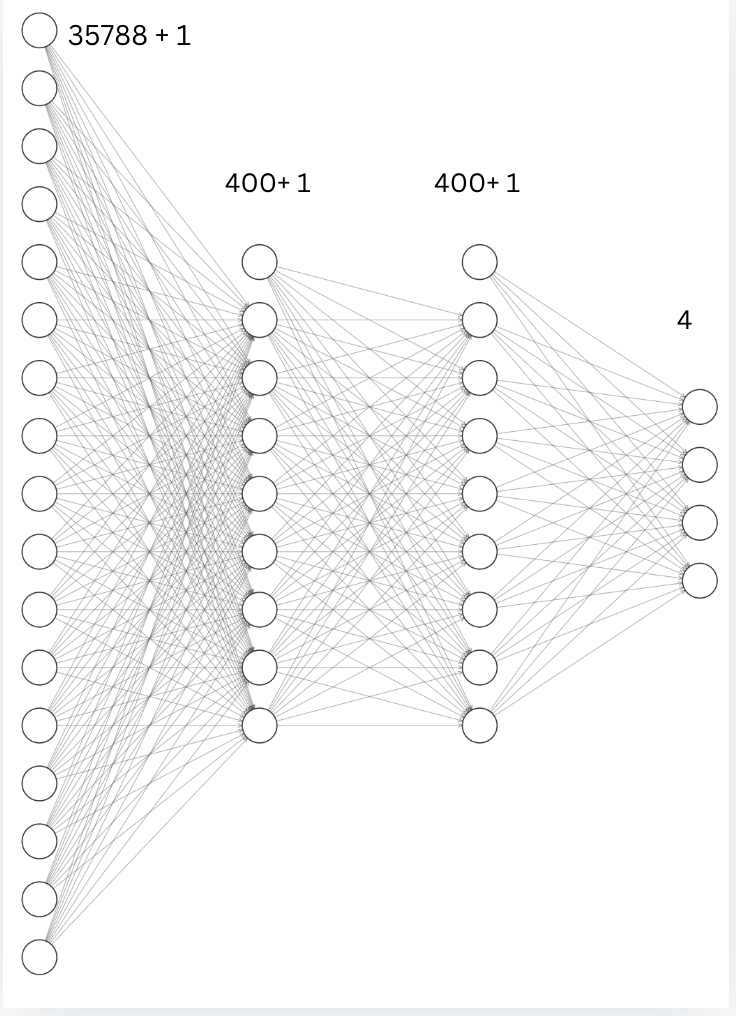
</div>

In [14]:
# Define a simple neural net architecture
class ClassifierModule(nn.Module):
    def __init__(
            self,
            nonlin = F.relu,
            input_dim = 35788, # feature size
            output_dim = 4, # number of target classes
            hidden_dim = 400,
    ):
        super(ClassifierModule, self).__init__()
        self.nonlin = nonlin
        self.dense0 = nn.Linear(input_dim, hidden_dim)
        self.dense1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.nonlin(self.dense1(X))
        X = self.output(X)
        return X

#### Let's break down the code!



```
class ClassifierModule(nn.Module):
  def __init__(
            self,
            nonlin = F.relu,
            input_dim = 35788, # feature size
            output_dim = 4, # number of target classes
            hidden_dim = 400,
    ):
```

We build a class ``` ClassiiferModule``` inheriting from ```torch.nn.Module```

[torch.nn.module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) is a base class for all neural network modules.

Inputs:

1. What non-linear activation function to use? ```nonlin```, default to ```F.relu```
2. What should be the input dimension? ```input_dim```, default to ```35788```
3. What should be the output dimension? ```output_dim```, default to ```4```
4. What should be the dimension of the hidden layer? ```hidden_dim```, default to ```400```

Note that although we have two hidden layers, we are keeping the dimensions of both the hidden layers same.

If you don't wish to do so, you could add additional parameters like ```hidden_dim1``` and ```hidden_dim2```



```
self.nonlin = nonlin
self.dense0 = nn.Linear(input_dim, hidden_dim)
self.dense1 = nn.Linear(hidden_dim, hidden_dim)
self.output = nn.Linear(hidden_dim, output_dim)
```

What does ```nn.Linear``` do?

1. ```nn.Linear``` is a class
```
self.dense0 = nn.Linear(input_dim, hidden_dim)
```
Here, we instantiate an ```nn.Linear``` object. A linear layer object with weights and biases is created. This object expects the shape (number of columns) of the input vector to be equal to ```input_dim``` and would give an output vector of the shape (number of columns) ```hidden_dim```

2. When called on an input ```x``` through ```self.dense0(x)``` a Linear Transformation: ```y=Ax+b``` is applied on ```x```. Note that it automatically creates a weight matrix ```A``` and bias vector ```b``` by using ```input_dim``` and ```hidden_dim```    

#### Example of using ```nn.Linear```

In [15]:
torch.manual_seed(42)

# Define a linear layer - Input should be of shape (1,3) and output (1,2)
linear_layer = nn.Linear(in_features=3, out_features=2)

# Create a sample input tensor
input_tensor = torch.tensor([[1.0, 2.0, 3.0]]) # 1 x 3 tensor

# Perform a forward pass through the linear layer
output_tensor = linear_layer(input_tensor)

# Print the output
print("Output:", output_tensor)
print("\n")
# Print the weight matrix
print("Weight matrix:", linear_layer.weight)
print("\n")
# Print the bias vector
print("Bias vector:", linear_layer.bias)

Output: tensor([[0.7130, 0.9659]], grad_fn=<AddmmBackward0>)


Weight matrix: Parameter containing:
tensor([[ 0.4414,  0.4792, -0.1353],
        [ 0.5304, -0.1265,  0.1165]], requires_grad=True)


Bias vector: Parameter containing:
tensor([-0.2811,  0.3391], requires_grad=True)


In [16]:
### Through Matrix Multiplication
### y = Ax + b
A = linear_layer.weight.detach().numpy()
x = input_tensor.detach().numpy()
b = linear_layer.bias.detach().numpy().reshape((2,1))

y = np.matmul(A, x.T) + b
y.T

array([[0.7129594 , 0.96594095]], dtype=float32)

```
def forward(self, X, **kwargs):
    X = self.nonlin(self.dense0(X))
    X = self.nonlin(self.dense1(X))
    X = self.output(X)
    return X
```

We chain everything in the ```forward``` function. Given an input ```X```

1. ```self.dense0(X)``` applies a linear transformation to ```X```. Note that ```X.shape[1] = input_dim```. Let ```Y = self.dense0(X)```. Then, ```Y.shape[1] = hidden_dim```. Now, ```self.nonlin(Y)``` applies a non-linear transformation - ```ReLU``` in this case.

2. We repeat the same process for the next hidden layer. Note again that the dimensions must match.

3. Finally, we get our outputs by using ```self.output(X)```  

#### How do the dimensions of X change?

```
class ClassifierModule(nn.Module):
    def __init__(
            self,
            nonlin = F.relu,
            input_dim = 35788, # feature size
            output_dim = 4, # number of target classes
            hidden_dim = 400,
    ):
        super(ClassifierModule, self).__init__()
        self.nonlin = nonlin
        self.dense0 = nn.Linear(input_dim, hidden_dim)
        self.dense1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.nonlin(self.dense1(X))
        X = self.output(X)
        return X
```

```X_train```: (2257, 35788)   

```X = self.nonlin(self.dense0(X))```

🗒❓ What is the dimension of X now?

```X = self.nonlin(self.dense1(X))```

🗒❓ What is the dimension of X now?

```X = self.output(X)```

🗒❓ What is the dimension of X now?

#### 🗒❓ Why do we use ```nn.Linear``` in the output layer? What about probabilities?

## Training

In [17]:
# Initialise the model with training hyperparameters
net = NeuralNetClassifier(
    ClassifierModule(
        nonlin=F.relu,
        input_dim=X_train_tfidf.shape[1],
        output_dim=label_encoder.classes_.shape[0],
        hidden_dim=400,
    ),
    max_epochs=10,
    criterion=nn.CrossEntropyLoss(),
    lr=0.1,
    batch_size=32,
    device='cuda',  # comment this to train with CPU
)


In [18]:
# Let's fit the model
net.fit(X_train_tfidf, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3847       0.2633        1.3821  0.9021
      2        1.3829       0.2633        1.3811  0.4926
      3        1.3818       0.3363        1.3799  0.4568
      4        1.3804       0.4270        1.3783  0.4854
      5        1.3784       0.4425        1.3758  0.4665
      6        1.3752       0.4403        1.3720  0.4725
      7        1.3701       0.4425        1.3652  0.4559
      8        1.3608       0.5177        1.3526  0.4737
      9        1.3425       0.6128        1.3268  0.4573
     10        1.3040       0.5664        1.2715  0.4995


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=35788, out_features=400, bias=True)
    (dense1): Linear(in_features=400, out_features=400, bias=True)
    (output): Linear(in_features=400, out_features=4, bias=True)
  ),
)

### 🗒❓ This performance doesn't look great. What could we try to improve the model's performance?





#### Increasing Epochs

In [25]:
# Initialise the model with training hyperparameters
net = NeuralNetClassifier(
    ClassifierModule(
        nonlin=F.relu,
        input_dim=X_train_tfidf.shape[1],
        output_dim=label_encoder.classes_.shape[0],
        hidden_dim=400,
    ),
    max_epochs=100,
    criterion=nn.CrossEntropyLoss(),
    lr=0.1,
    batch_size=32,
    device='cuda',  # comment this to train with CPU
)

In [26]:
# Let's fit the model
net.fit(X_train_tfidf, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3842       0.2633        1.3819  0.4727
      2        1.3827       0.2699        1.3809  0.4757
      3        1.3816       0.3274        1.3796  0.4743
      4        1.3801       0.3982        1.3779  0.4860
      5        1.3779       0.4314        1.3753  0.5860
      6        1.3746       0.4469        1.3712  0.5961
      7        1.3691       0.4425        1.3641  0.5878
      8        1.3594       0.5465        1.3510  0.6259
      9        1.3405       0.6150        1.3246  0.6023
     10        1.3017       0.5730        1.2700  0.5122
     11        1.2248       0.5597        1.1707  0.5083
     12        1.1061       0.5996        1.0482  0.4983
     13        0.9775       0.6681        0.9370  0.4987
     14        0.8572       0.7102        0.8424  0.4967
     15        0.7451       0.7035        0.7694  0.4845
     16        0.6405       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=35788, out_features=400, bias=True)
    (dense1): Linear(in_features=400, out_features=400, bias=True)
    (output): Linear(in_features=400, out_features=4, bias=True)
  ),
)

## Evaluation

In [27]:
# Don't forget to set the datatype for the test data!
X_test_tfidf = X_test_tfidf.astype(np.float32)
y_test = y_test.astype(np.int64)

# Get the model's predictions
y_pred = net.predict(X_test_tfidf)
print(y_pred)

[2 2 2 ... 2 2 1]


Acc: 0.899


Classification Report:

                        precision    recall  f1-score   support

           alt.atheism      0.924     0.837     0.878       319
         comp.graphics      0.969     0.879     0.922       389
               sci.med      0.815     0.955     0.879       396
soc.religion.christian      0.917     0.912     0.914       398

              accuracy                          0.899      1502
             macro avg      0.906     0.896     0.898      1502
          weighted avg      0.905     0.899     0.899      1502


Confusion Matrix:



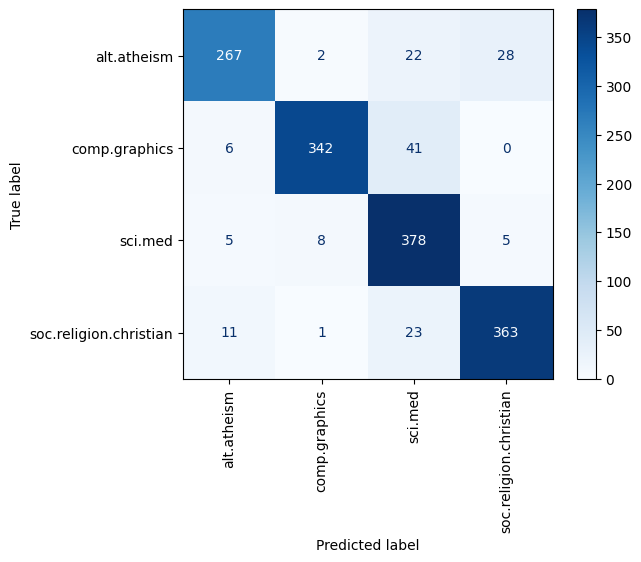

In [28]:
# Evaluate on test data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

print(f'Acc: {accuracy_score(y_test, y_pred):.3f}\n')

# Classification Report (per class metrics)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, digits=3))

# Confusion Matrix
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred)

# # show confusion matrix in a simple numerical representation:
# print(cm)

# or for more visual rep, plot it as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=90)


### 🗒❓ What more could we try to improve the model's performance?
